In [338]:
import numpy as np
import pandas as pd
import librosa as lib
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix,multilabel_confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


## Importar los rttm y convertirlos en un df

In [339]:
import numpy as np
import pandas as pd

def read_rttm(file_path):
    columns = ['Type', 'File ID', 'Channel', 'Start Time', 'Duration', 'Ortho', 'Ortho1', 'SType', 'Conf']
    df = pd.read_csv(file_path, delim_whitespace=True, header=None, names=columns)
    df['Start Time'] = df['Start Time'].astype(float)
    df['Duration'] = df['Duration'].astype(float)
    df['Conf'] = df['Conf'].astype(float)
    return df

def read_rttm_diar(file_path):
    columns = ['Type', 'File ID', 'Channel', 'Start Time', 'Duration', 'Ortho1', 'Ortho2', 'SType', 'Name1', 'Name2']
    df = pd.read_csv(file_path, delim_whitespace=True, header=None, names=columns)
    df['Start Time'] = df['Start Time'].astype(float)
    df['Duration'] = df['Duration'].astype(float)
    return df

file_path_rttm = 'casos/donatow-a1-nsm/donatow-a1-nsm.rttm'
file_path_diar = 'casos/donatow-a1-nsm/donatow-a1-nsm-diarization.rttm'

df_rttm = read_rttm(file_path_rttm)
df_rttm_diar = read_rttm_diar(file_path_diar)

# Modificar columnas
df_rttm['Type'] = 'Elan'
df_rttm['STypeNew'] = df_rttm['SType'].map({
    'CHI': 'KCHI',
    
    'MOT': 'FEM',
    'MUJ': 'FEM',
    'MU1': 'FEM',
    'MU2': 'FEM',
    'MU3': 'FEM',
    'MU4': 'FEM',
    'MU5': 'FEM',
    'MU6': 'FEM',
    'MU7': 'FEM',
    'WOM': 'FEM',
    'WO1': 'FEM',
    'WO2': 'FEM',
    'WO3': 'FEM',
    'WO4': 'FEM',
    'WO5': 'FEM',
    'GMA': 'FEM',
    'MAM': 'FEM',
    'ABA': 'FEM',
    'TÍA': 'FEM',
    'TIA': 'FEM',
    'PRI': 'FEM',
    'MAE': 'FEM',
    'MA1': 'FEM',
    'MA2': 'FEM',
    'MAT': 'FEM',
    'ADO': 'FEM',
    'FEL': 'FEM',
    'NOE': 'FEM',
    'OBS': 'FEM', 
    
    'ABU': 'FEM',
    'ABO': 'MAL',
    'GMP': 'MAL',
    'GPA': 'MAL',
    'FAT': 'MAL',
    'UNC': 'MAL',
    'TIO': 'MAL',
    'PAP': 'MAL',
    'HOM': 'MAL',
    'HO1': 'MAL',
    'HO2': 'MAL',
    'HO3': 'MAL',
    'HO4': 'MAL',
    'HO5': 'MAL',
    'POR': 'MAL',
    
    'BOY': 'OCH',
    'SIS': 'OCH',
    'SAN': 'OCH',
    'NIN': 'OCH',    
    'NIA': 'OCH',
    'NIO': 'OCH',
    'NI1': 'OCH',
    'NI0': 'OCH',
    'NI2': 'OCH',
    'NI3': 'OCH',
    'BRO': 'OCH',
    'CH2': 'OCH',
    'BEB': 'OCH'
})
df_rttm = df_rttm[['Type', 'File ID', 'Start Time', 'Duration', 'STypeNew']]

df_rttm_diar['Type'] = 'Diar'
df_rttm_diar['STypeNew'] = df_rttm_diar['SType'].map({'CHI': 'OCH',
                                                      'FEM': 'FEM',
                                                      'MAL': 'MAL',
                                                      'KCHI': 'KCHI',
                                                      'SPEECH':'SPEECH' })
df_rttm_diar = df_rttm_diar[['Type', 'File ID', 'Start Time', 'Duration', 'STypeNew']]

# Concatenar DataFrames
df_both = pd.concat([df_rttm, df_rttm_diar])

# Extraer el nombre entre 'casos/' y la siguiente '/'
name = file_path_rttm.split('/')[1]


print(name)

# Verificar el contenido del DataFrame concatenado
print("Contenido de df_both:")
print(df_both)

donatow-a1-nsm
Contenido de df_both:
      Type                     File ID  Start Time  Duration STypeNew
0     Elan              donatow-a1-nsm       0.000  5209.760     KCHI
1     Elan              donatow-a1-nsm    5209.760     8.120     KCHI
2     Elan              donatow-a1-nsm    5217.880     0.970     KCHI
3     Elan              donatow-a1-nsm    5219.520     1.170     KCHI
4     Elan              donatow-a1-nsm    5227.860     2.210     KCHI
...    ...                         ...         ...       ...      ...
3065  Diar  donatow-a1-nsm.diarization   13997.490     1.264   SPEECH
3066  Diar  donatow-a1-nsm.diarization   13997.490     1.298      FEM
3067  Diar  donatow-a1-nsm.diarization   14000.367     0.640   SPEECH
3068  Diar  donatow-a1-nsm.diarization   14004.487     1.716   SPEECH
3069  Diar  donatow-a1-nsm.diarization   14004.492     1.623      FEM

[4627 rows x 5 columns]


In [340]:
df_both["STypeNew"].unique()
# Eliminar filas con NaN en la columna 'STypeNew'
df_both = df_both.dropna(subset=['STypeNew'])


In [341]:
df_both.to_csv(f"casos/{name}/df_both_{name}.csv")

In [342]:
# Define las variables para el análisis
start = 3625
end = 10825
step = 0.1

# Inicializa listas para resultados
results = {
    'Elan_KCHI': [],
    'Elan_OCH': [],
    'Elan_FEM': [],
    'Elan_MAL': [],
    'Diar_KCHI': [],
    'Diar_OCH': [],
    'Diar_FEM': [],
    'Diar_MAL': []
}


In [343]:
# Crear la barra de progreso
num_steps = int((end - start) / step)  # Calcular el número total de pasos
with tqdm(total=num_steps, desc="Processing intervals") as pbar:
    # Analizar intervalos
    for i in np.arange(start, end, step):
        # Verificar presencia de cada tipo en el intervalo
        for key in results.keys():
            results[key].append(int(df_both[
                (df_both['Start Time'] <= i) & 
                (df_both['Start Time'] + df_both['Duration'] > i) & 
                (df_both['STypeNew'] == key.split('_')[1]) & 
                (df_both['Type'] == key.split('_')[0])
            ].shape[0] > 0))
        
        # Actualizar la barra de progreso
        pbar.update(1)

# Crear DataFrame de resultados
df_results= pd.DataFrame(results)

# Verificar el contenido del DataFrame de resultados
print("Contenido de df_results:")
print(df_results.head())

Processing intervals: 100%|██████████| 72000/72000 [12:57<00:00, 92.65it/s]  

Contenido de df_results:
   Elan_KCHI  Elan_OCH  Elan_FEM  Elan_MAL  Diar_KCHI  Diar_OCH  Diar_FEM  \
0          1         0         0         0          0         0         0   
1          1         0         0         0          0         0         0   
2          1         0         0         0          0         0         0   
3          1         0         0         0          0         0         0   
4          1         0         0         0          0         0         0   

   Diar_MAL  
0         0  
1         0  
2         0  
3         0  
4         0  


In [344]:
df_results.to_csv(f"casos/{name}/df_results_{name}.csv", index=False)


In [345]:
df_resultados= pd.read_csv(f"casos/{name}/df_results_{name}.csv")
df_resultados

,Elan_KCHI,Elan_OCH,Elan_FEM,Elan_MAL,Diar_KCHI,Diar_OCH,Diar_FEM,Diar_MAL
0,1,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
71995,0,0,1,0,0,0,1,0
71996,0,0,1,0,0,0,0,0
71997,0,0,1,0,0,0,0,0
71998,0,0,1,0,0,0,0,0


In [346]:
# Definir las etiquetas
labels = ['KCHI', 'OCH', 'FEM', 'MAL']

# Extraer las etiquetas verdaderas y predichas
y_true = df_resultados[['Elan_KCHI', 'Elan_OCH', 'Elan_FEM', 'Elan_MAL']].values
y_pred = df_resultados[['Diar_KCHI', 'Diar_OCH', 'Diar_FEM', 'Diar_MAL']].values

# Calcular la matriz de confusión multilabel
conf_matrix = multilabel_confusion_matrix(y_true, y_pred)

# Mostrar la matriz de confusión para cada etiqueta
for i, label in enumerate(labels):
    print(f"Matriz de confusión para la etiqueta {label}:")
    print(conf_matrix[i])
    print()

# Opcionalmente, puedes imprimir un informe de clasificación
print("Informe de clasificación:")
print(classification_report(y_true, y_pred, target_names=labels))


Matriz de confusión para la etiqueta KCHI:
[[20484  2109]
 [45244  4163]]

Matriz de confusión para la etiqueta OCH:
[[69446  2402]
 [  151     1]]

Matriz de confusión para la etiqueta FEM:
[[47890  3897]
 [14116  6097]]

Matriz de confusión para la etiqueta MAL:
[[70498   334]
 [ 1156    12]]

Informe de clasificación:
              precision    recall  f1-score   support

        KCHI       0.66      0.08      0.15     49407
         OCH       0.00      0.01      0.00       152
         FEM       0.61      0.30      0.40     20213
         MAL       0.03      0.01      0.02      1168

   micro avg       0.54      0.14      0.23     70940
   macro avg       0.33      0.10      0.14     70940
weighted avg       0.64      0.14      0.22     70940
 samples avg       0.14      0.14      0.14     70940



C:\Users\pablo\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pablo\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


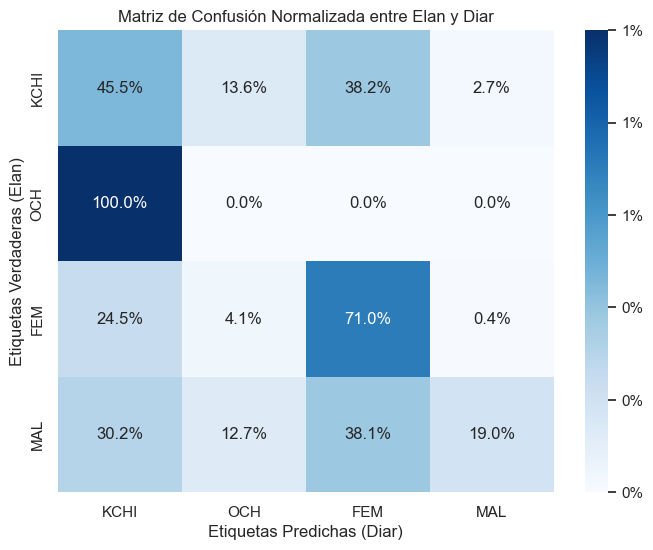

In [347]:
# Conversión de etiquetas multilabel a etiquetas de clase única (mismo código que antes)
def multilabel_to_singlelabel(y_multilabel):
    single_labels = []
    for row in y_multilabel:
        indices = np.where(row == 1)[0]
        if len(indices) == 0:
            single_labels.append(-1)  # Sin etiqueta
        else:
            # Si hay múltiples etiquetas, puedes decidir cómo manejarlas.
            # Aquí, tomamos la primera etiqueta encontrada.
            single_labels.append(indices[0])
    return np.array(single_labels)

y_true = multilabel_to_singlelabel(y_true)
y_pred = multilabel_to_singlelabel(y_pred)

# Filtrar las instancias sin etiqueta
valid_indices = y_true != -1
y_true = y_true[valid_indices]
y_pred = y_pred[valid_indices]

# Calcular la matriz de confusión normalizada
cm = confusion_matrix(y_true, y_pred, labels=range(len(labels)), normalize='true')

# Crear un DataFrame para la matriz de confusión
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

# Crear las anotaciones con porcentajes
annot = cm_df.applymap(lambda x: '{0:.1f}%'.format(x*100))


# Crear el gráfico de la matriz de confusión con porcentajes
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=annot, fmt='', cmap='Blues', cbar_kws={'format': '%.0f%%'})
plt.title('Matriz de Confusión Normalizada entre Elan y Diar')
plt.ylabel('Etiquetas Verdaderas (Elan)')
plt.xlabel('Etiquetas Predichas (Diar)')

# Guardar la figura como un archivo PNG
plt.savefig(f'casos/{name}/matriz_confusion_{name}.png', dpi=300, bbox_inches='tight')

plt.show()


In [348]:
# Cálculo de precisión, recall y F1-score
types = ['KCHI', 'OCH', 'FEM', 'MAL']

# Inicializar listas para almacenar las métricas
metrics = {
    'Tipo': [],
    'Precisión': [],
    'Recall': [],
    'F1-score': []
}

print("\nCalculando métricas de precisión, recall y F1-score:")
for t in tqdm(types, desc="Procesando tipos"):
    y_true = df_results['Elan_' + t]
    y_pred = df_results['Diar_' + t]
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    # Almacenar las métricas
    metrics['Tipo'].append(t)
    metrics['Precisión'].append(precision)
    metrics['Recall'].append(recall)
    metrics['F1-score'].append(f1)
    
    # Imprimir los resultados
    print(f"\nResultados para el tipo {t}:")
    print(f"Precisión: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

# Crear DataFrame de métricas
df_metrics = pd.DataFrame(metrics)


Calculando métricas de precisión, recall y F1-score:


Procesando tipos: 100%|██████████| 4/4 [00:00<00:00, 19.85it/s]


Resultados para el tipo KCHI:
Precisión: 0.6637
Recall: 0.0843
F1-score: 0.1495

Resultados para el tipo OCH:
Precisión: 0.0004
Recall: 0.0066
F1-score: 0.0008

Resultados para el tipo FEM:
Precisión: 0.6101
Recall: 0.3016
F1-score: 0.4037

Resultados para el tipo MAL:
Precisión: 0.0347
Recall: 0.0103
F1-score: 0.0159


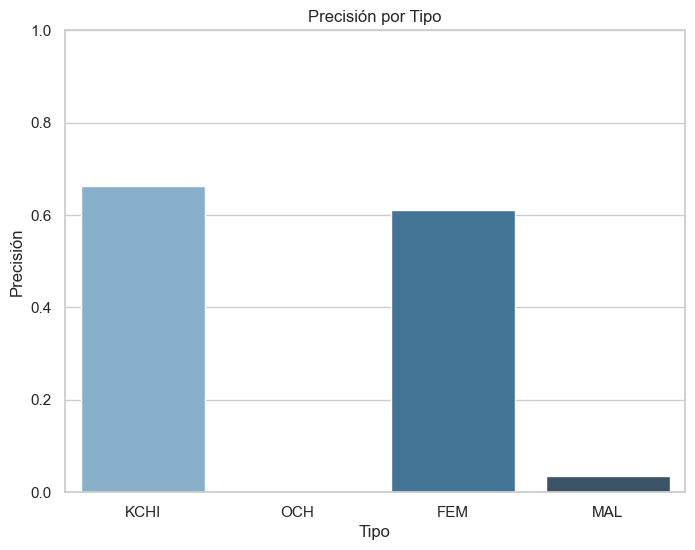

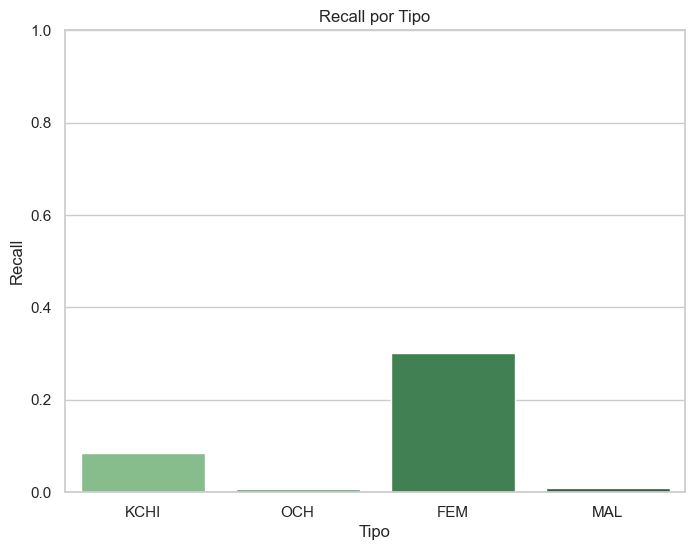

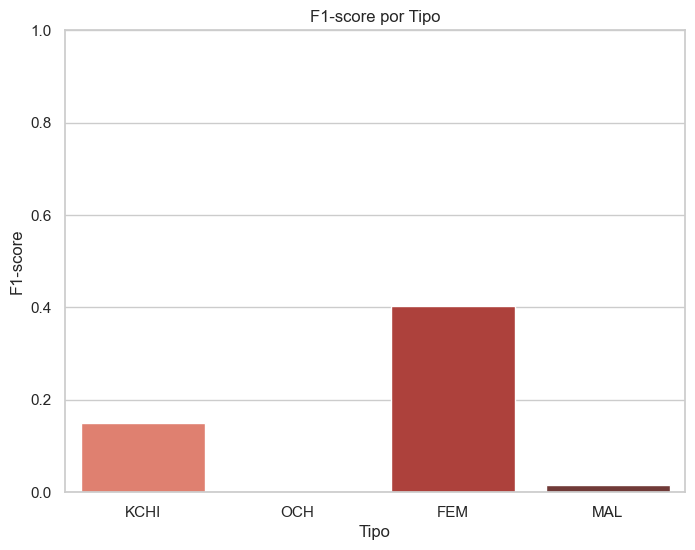

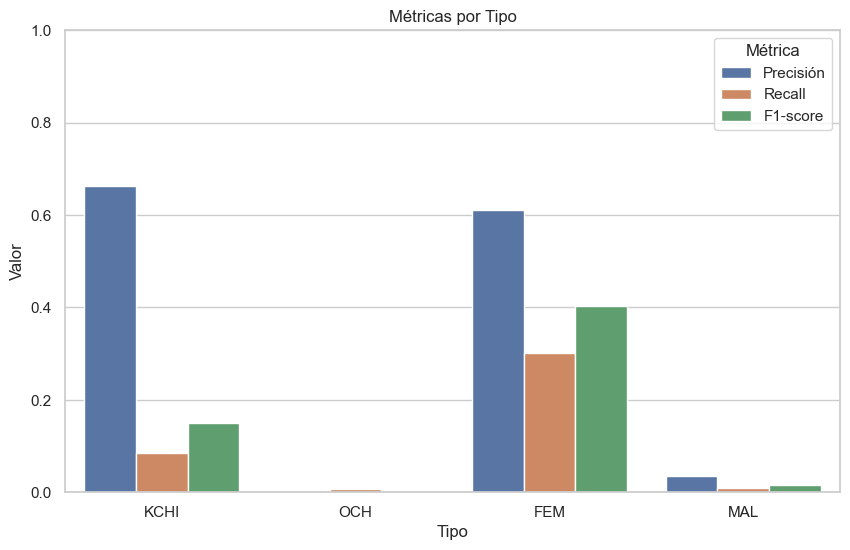

In [349]:
# Generar gráficos
sns.set(style="whitegrid")

# Gráfico de barras para Precisión
plt.figure(figsize=(8, 6))
sns.barplot(x='Tipo', y='Precisión', data=df_metrics, palette='Blues_d')
plt.title('Precisión por Tipo')
plt.ylim(0, 1)
plt.ylabel('Precisión')

# Guardar la figura como un archivo PNG
plt.savefig(f'casos/{name}/precision_{name}.png', dpi=300, bbox_inches='tight')

plt.show()

# Gráfico de barras para Recall
plt.figure(figsize=(8, 6))
sns.barplot(x='Tipo', y='Recall', data=df_metrics, palette='Greens_d')
plt.title('Recall por Tipo')
plt.ylim(0, 1)
plt.ylabel('Recall')

# Guardar la figura como un archivo PNG
plt.savefig(f'casos/{name}/recall_{name}.png', dpi=300, bbox_inches='tight')

plt.show()

# Gráfico de barras para F1-score
plt.figure(figsize=(8, 6))
sns.barplot(x='Tipo', y='F1-score', data=df_metrics, palette='Reds_d')
plt.title('F1-score por Tipo')
plt.ylim(0, 1)
plt.ylabel('F1-score')
# Guardar la figura como un archivo PNG
plt.savefig(f'casos/{name}/f1score_{name}.png', dpi=300, bbox_inches='tight')
plt.show()

# Gráfico combinado
df_metrics_melted = pd.melt(df_metrics, id_vars=['Tipo'], value_vars=['Precisión', 'Recall', 'F1-score'], var_name='Métrica', value_name='Valor')

plt.figure(figsize=(10, 6))
sns.barplot(x='Tipo', y='Valor', hue='Métrica', data=df_metrics_melted)
plt.title('Métricas por Tipo')
plt.ylim(0, 1)
plt.ylabel('Valor')
plt.legend(title='Métrica')

# Guardar la figura como un archivo PNG
plt.savefig(f'casos/{name}/combinado_{name}.png', dpi=300, bbox_inches='tight')

plt.show()


In [350]:
# Seleccionar las columnas que empiezan con "Diar_"
diar_columns = [col for col in df_resultados.columns if col.startswith('Diar_')]

# Cambiar los valores de 1 a 0.8 en esas columnas
df_resultados[diar_columns] = df_resultados[diar_columns].replace(1, 0.8)

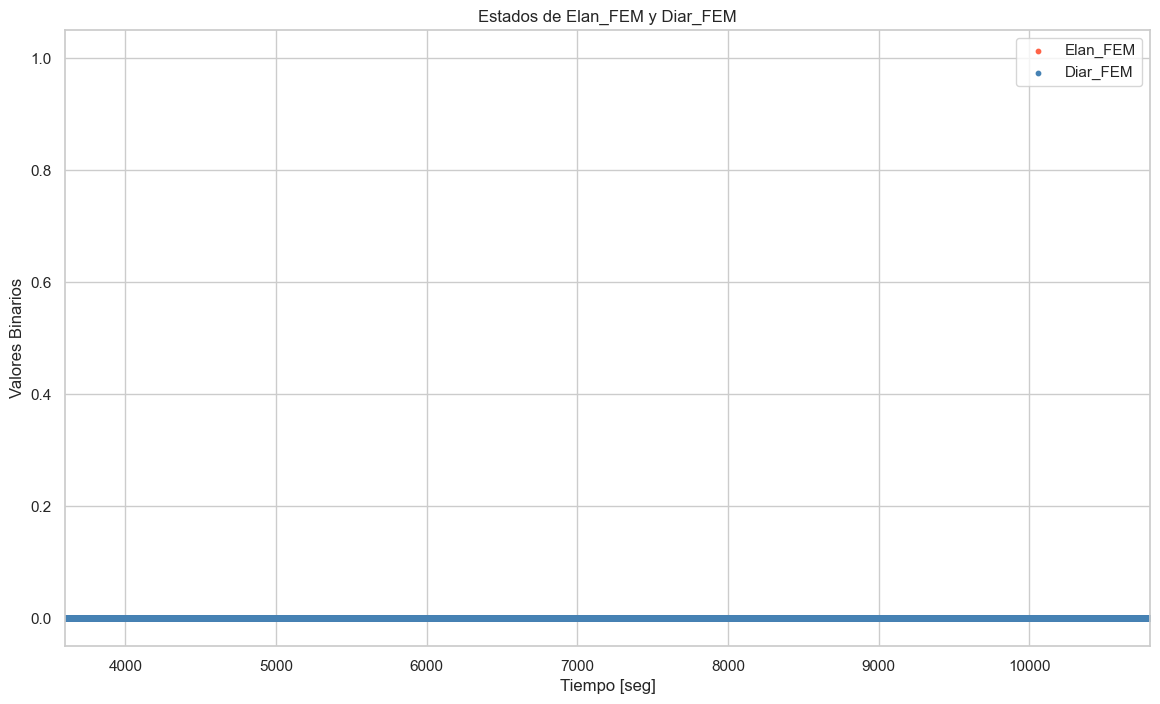

In [351]:
# Definir las columnas que deseas graficar
columns_to_plot = ['Elan_FEM', 'Diar_FEM']

# Definir colores contrastantes
colors = ['#FF6347', '#4682B4']  # Tomato y SteelBlue

# Crear la gráfica de dispersión para mostrar solo los estados sin transiciones
plt.figure(figsize=(14, 8))

# Graficar solo los puntos donde el valor es 1
for i, column in enumerate(columns_to_plot):
    plt.scatter(df_resultados.index, df_resultados[column], label=column, color=colors[i], s=10)

# Configuración del gráfico
plt.title('Estados de Elan_FEM y Diar_FEM')
plt.xlabel('Tiempo [seg]')
plt.ylabel('Valores Binarios')
plt.legend(loc='upper right')
plt.grid(True)
plt.xlim(3600, 10800)

# Guardar la figura como un archivo PNG
# plt.savefig(f'binarios_{name}.png', dpi=300, bbox_inches='tight')
# Mostrar la gráfica
plt.show()


In [352]:
# # Definir las columnas que deseas graficar
# columns_to_plot = ['Elan_FEM', 'Diar_FEM']

# # Definir colores contrastantes
# colors = ['#FF6347', '#4682B4']  # Tomato y SteelBlue

# # Crear la gráfica de dispersión para mostrar solo los estados sin transiciones
# plt.figure(figsize=(14, 8))

# # Graficar solo los puntos donde el valor es 1
# for i, column in enumerate(columns_to_plot):
#     plt.scatter(df_resultados.index, df_resultados[column], label=column, color=colors[i], s=10)

# # Configuración del gráfico
# plt.title('Estados de Elan_FEM y Diar_FEM')
# plt.xlabel('Tiempo [seg]')
# plt.ylabel('Valores Binarios')
# plt.legend(loc='upper right')
# plt.grid(True)
# plt.xlim(1000, 1400)

# # Guardar la figura como un archivo PNG
# # plt.savefig(f'binariosShort_{name}.png', dpi=300, bbox_inches='tight')

# # Mostrar la gráfica
# plt.show()